# Scoring
Produce a geoJSON file containing the trueskill score associated to the perceived safety of a certain location (by analyzing pictures of that location)

### Imports

In [2]:
# Import libraries
import trueskill
import tensorflow
from tensorflow.keras.models import Model, Sequential, load_model
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
import json
import os
from IPython.display import display, Markdown, Latex
import logging
import random
import csv
import itertools

logger = tensorflow.get_logger()
logger.setLevel(logging.ERROR)

### Variables
Adjust these to reflect the desired input and output files

In [3]:
network_path = "models/atmos_finetuning_full.h5"
training_path = "enhanced_preproc/"
data_path = "data/"
csv_name = "scoring.csv"
img_folder = "data/images/"
output_file = "output/safety_stgallen_27k_exp30.geojson"
training_size = 30

### Setup
Select which GPU to use when several are available. This can be removed when few GPUs are available

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

Load pretrained ML model to compare image couples

In [7]:
siamese_net = load_model(network_path)

Select images from training set to be used as a baseline to compute trueskill score of other images

In [8]:
# Load training images
training_images = {}

# Select, load and preprocess 30 random items from the training set 
for f in random.sample(os.listdir(training_path), training_size):
    training_images[f[:-4]] = preprocess_input(cv2.imread(training_path+f))

Compute trueskill score of all images used as training images

In [9]:
training_scores = {id : trueskill.Rating() for id in training_images}

In [10]:
trainingCouples = itertools.combinations(training_images.keys(), 2)

leftIds = []
rightIds = []

for c in trainingCouples:
    leftIds.append(c[0])
    rightIds.append(c[1])

left = np.array([training_images[l] for l in leftIds])
right = np.array([training_images[r] for r in rightIds])

result = siamese_net.predict([left, right])

for j,r in enumerate(result):
    if r[1]>r[0]: #left wins
        newL, newR = trueskill.rate_1vs1(training_scores[leftIds[j]], training_scores[rightIds[j]])
        training_scores[leftIds[j]] = newL
        training_scores[rightIds[j]] = newR
    else:
        newR, newL = trueskill.rate_1vs1(training_scores[rightIds[j]], training_scores[leftIds[j]])
        training_scores[leftIds[j]] = newL
        training_scores[rightIds[j]] = newR

2022-02-20 18:31:21.952296: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-20 18:31:21.971065: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


### Data loading
Create dictionary containing images to be scored from csv file, and associated metadata

In [11]:
metadata = {}
with open(data_path+csv_name) as f:
    csv_data = csv.reader(f)
    print(next(csv_data))
    for r in csv_data:
        metadata[r[0]] = {"coord": [r[2], r[3]], "score": trueskill.Rating()}

['287913436159193', 'SG', '47.42343090829024', '9.373145699501038', '249.0554', '7PrfKl3VD3IciasEJplicA', '1443159799764', 'False']


Load and preprocess images to be scored

In [12]:
images = {}
for imName in metadata.keys():
    im = cv2.imread(img_folder+imName+".jpg")

    if im is not None:
        im = cv2.resize(im, (224, 224), interpolation=cv2.INTER_CUBIC)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        images[imName] = preprocess_input(im)

[ WARN:0@337.643] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('data/images/7PrfKl3VD3IciasEJplicA.jpg'): can't open/read file: check file path/integrity


### Scores computation
Compute scores for images to be analyzed by comparing them with images from the training set

In [13]:
trainIds = np.array(list(training_images.keys()))
i = 0
m = len(images.keys())
                    
for imgId, img in images.items():
    i+=1
    print(i/m*100, end = '\r')
    left = np.array([training_images[tId] for tId in trainIds])
    right = np.array([img for tId in trainIds])

    result = siamese_net.predict([left, right])

    for j,r in enumerate(result):
        if r[1]>r[0]: #left wins
            _ ,metadata[imgId]["score"] = trueskill.rate_1vs1(training_scores[leftIds[j]], metadata[imgId]["score"])
        else: #right wins
            metadata[imgId]["score"], _ = trueskill.rate_1vs1(metadata[imgId]["score"], training_scores[leftIds[j]])

Keep only the "mu" value of the trueskill scores

In [14]:
# Experimental: compare also the analyzed images
i = 0
m = len(images.keys())
                    
for imgId, img in images.items():
    i+=1
    print(i/m*100, end = '\r')
    leftIds = [tId for tId in random.sample(images.keys(),30)]
    left = np.array([images[tId] for tId in leftIds])
    right = np.array([img for tId in range(0,30)])

    result = siamese_net.predict([left, right])

    for j,r in enumerate(result):
        if r[1]>r[0]: #left wins
            metadata[leftIds[j]]["score"] ,metadata[imgId]["score"] = trueskill.rate_1vs1(metadata[leftIds[j]]["score"], metadata[imgId]["score"])
        else: #right wins
            metadata[imgId]["score"], metadata[leftIds[j]]["score"] = trueskill.rate_1vs1(metadata[imgId]["score"], metadata[leftIds[j]]["score"])

KeyboardInterrupt: 

In [19]:
results = {}
mink = list(metadata.keys())[0]
maxk = list(metadata.keys())[0]

for k in metadata.keys():
    if type(metadata[k]["score"]) is dict:
        metadata[k]["score"] = metadata[k]["score"].mu
    
    if metadata[k]["score"] > metadata[maxk]["score"]:
        maxk = k
    if metadata[k]["score"] < metadata[mink]["score"]:
        mink = k  

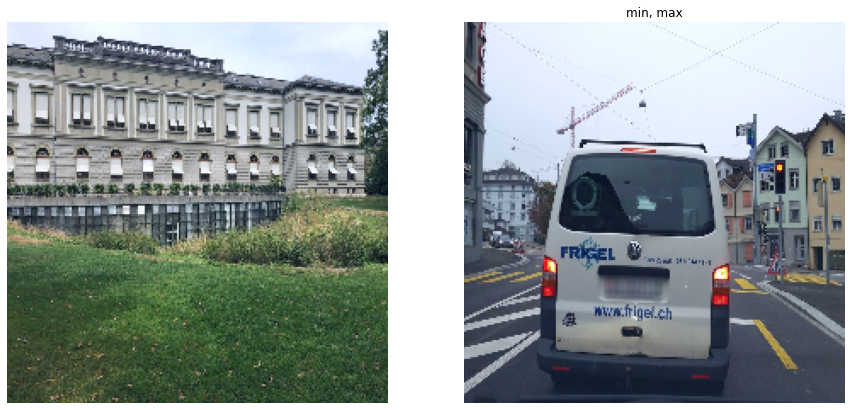

In [20]:
def display_images(im1, im2, label):
    im1 = im1+127.5
    im1[im1>255] = 255
    im1 = cv2.cvtColor(im1.astype(np.uint8), cv2.COLOR_BGR2RGB)
    im2 = im2+127.5
    im2[im2>255] = 255
    im2 = cv2.cvtColor(im2.astype(np.uint8), cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,10))
    ax1.imshow(im1)
    ax1.axis('off')
    ax2.imshow(im2)
    ax2.axis('off')
    plt.title(label)
    plt.show()

display_images(images[mink], images[maxk], "min, max")

Transform data to geoJSON format

In [21]:
geojson = {"type": "FeatureCollection",
  "features":[]}

for k, v in metadata.items():
    geojson["features"].append({"type": "Feature",
                   "properties": {
                       "name": k,
                       "score": v["score"]
                   },
                   "geometry": {
                       "type": "Point",
                       "coordinates": [float(v["coord"][1]), float(v["coord"][0])]
                   }})

Save geoJSON data to external json file

In [22]:
with open(output_file, 'w') as fp:
    json.dump(geojson, fp)